# Train Ulmo on llc modis-2012 data with 10 percent training

In [1]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [2]:
import numpy as np
import h5py
from ulmo.models import DCAE, ConditionalFlow
from ulmo.ood import ProbabilisticAutoencoder

Cartopy not installed.  Some plots will not work!


## Split the data set into 'train' and 'valid' part

In [14]:
filepath = '/home/jovyan/ulmo/ulmo/runs/LLC/experiments/datasets/llc_modis_2012/LLC_modis2012_test_preproc.h5'

In [15]:
with h5py.File(filepath, 'r') as f:
    print(f.keys())
    len_valid = f['valid'].shape[0]
    print(f'sample size is: {len_valid}.')
    modis_2012 = f['valid'][:]

<KeysViewHDF5 ['valid', 'valid_metadata']>
sample size is: 635295.


## Get the indices of the training and validation set

In [16]:
np.random.seed(0)
train_size = 100000
test_size = len_valid - train_size
sample_indices_shuffled = np.random.permutation(np.arange(len_valid))
train_indices = sample_indices_shuffled[:train_size]
test_indices = sample_indices_shuffled[train_size:]
assert train_indices.shape[0] + test_indices.shape[0] == len_valid, "Split is wrong!"
assert (set(train_indices) & set(test_indices)) == set([]), "Split is wrong!"

In [17]:
llc_modis_2012_train = modis_2012[train_indices]
llc_modis_2012_test = modis_2012[test_indices]

## Create new h5py file with train and valid

In [3]:
filepath_split = '/home/jovyan/ulmo/ulmo/runs/LLC/experiments/datasets/llc_modis_2012/LLC_modis2012_test_preproc_split.h5'

In [22]:
with h5py.File(filepath_split, 'w') as f:
    f.create_dataset('train', data=llc_modis_2012_train)
    f.create_dataset('valid', data=llc_modis_2012_test)
    f.create_dataset('train_indices', data=train_indices)
    f.create_dataset('valid_indices', data=test_indices)

In [8]:
with h5py.File(filepath_split, 'r') as f:
    print(f.keys())
    f['train'][:]

<KeysViewHDF5 ['train', 'train_indices', 'valid', 'valid_indices']>


## Train Autoencoder

In [4]:
autoencoder = DCAE(image_shape=(1, 64, 64), latent_dim=512)

In [5]:
flow = ConditionalFlow(
    dim=512, 
    context_dim=None, 
    transform_type='autoregressive', 
    n_layers=10, 
    hidden_units=256,
    n_blocks=2, 
    dropout=0.2, 
    use_batch_norm=False, 
    tails='linear', 
    tail_bound=10, 
    n_bins=5,
    min_bin_height=1e-3, 
    min_bin_width=1e-3, 
    min_derivative=1e-3, 
    unconditional_transform=False, 
    encoder=None)

In [6]:
pae = ProbabilisticAutoencoder(autoencoder=autoencoder, flow=flow, filepath=filepath_split)

Using device=cuda
Wrote model parameters to ./model.json


99,840 training samples. 535,040 validation samples.


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/195 [00:01<?, ?batch/s]

  0%|          | 0/195 [00:01<?, ?batch/s]

  0%|          | 0/195 [00:01<?, ?batch/s]

  0%|          | 0/195 [00:01<?, ?batch/s]

  0%|          | 0/195 [00:01<?, ?batch/s]

  0%|          | 0/195 [00:01<?, ?batch/s]

  0%|          | 0/195 [00:01<?, ?batch/s]

  0%|          | 0/195 [00:01<?, ?batch/s]

  0%|          | 0/195 [00:01<?, ?batch/s]

  0%|          | 0/195 [00:01<?, ?batch/s]

Training stopped. Save model (y/n)? y


Model saved.
Loading autoencoder model from: ./autoencoder.pt


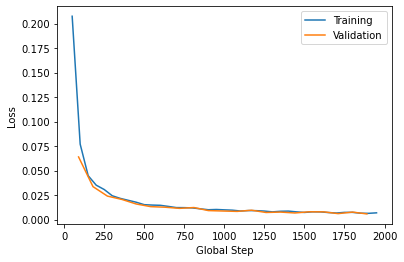

In [7]:
pae.train_autoencoder(n_epochs=10, batch_size=512, lr=2.5e-3, summary_interval=50, eval_interval=90)

## Train Flow

Existing latents file found. Use file (y) or recompute (n)? y


99,840 training samples. 535,040 validation samples.


  0%|          | 0/30 [00:00<?, ?epoch/s]

  0%|          | 0/195 [00:01<?, ?batch/s]

  0%|          | 0/195 [00:01<?, ?batch/s]

  0%|          | 0/195 [00:01<?, ?batch/s]

  0%|          | 0/195 [00:01<?, ?batch/s]

  0%|          | 0/195 [00:01<?, ?batch/s]

  0%|          | 0/195 [00:00<?, ?batch/s]

  0%|          | 0/195 [00:00<?, ?batch/s]

  0%|          | 0/195 [00:00<?, ?batch/s]

  0%|          | 0/195 [00:00<?, ?batch/s]

  0%|          | 0/195 [00:00<?, ?batch/s]

  0%|          | 0/195 [00:00<?, ?batch/s]

  0%|          | 0/195 [00:00<?, ?batch/s]

  0%|          | 0/195 [00:00<?, ?batch/s]

  0%|          | 0/195 [00:01<?, ?batch/s]

Training stopped. Save model (y/n)? y


Model saved.
Loading flow model from: ./flow.pt


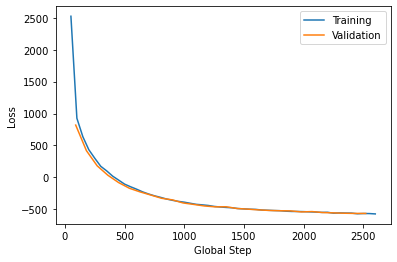

In [7]:
pae.train_flow(n_epochs=30, batch_size=512, lr=2.5e-4, summary_interval=50, eval_interval=90)

## Histogram of the Evaluation

Existing log probs file found. Use file (y) or recompute (n)? y


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


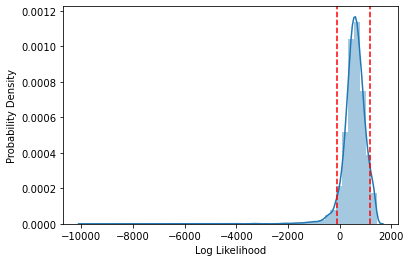

In [7]:
pae.plot_log_probs()

## Show Cutouts Galleries

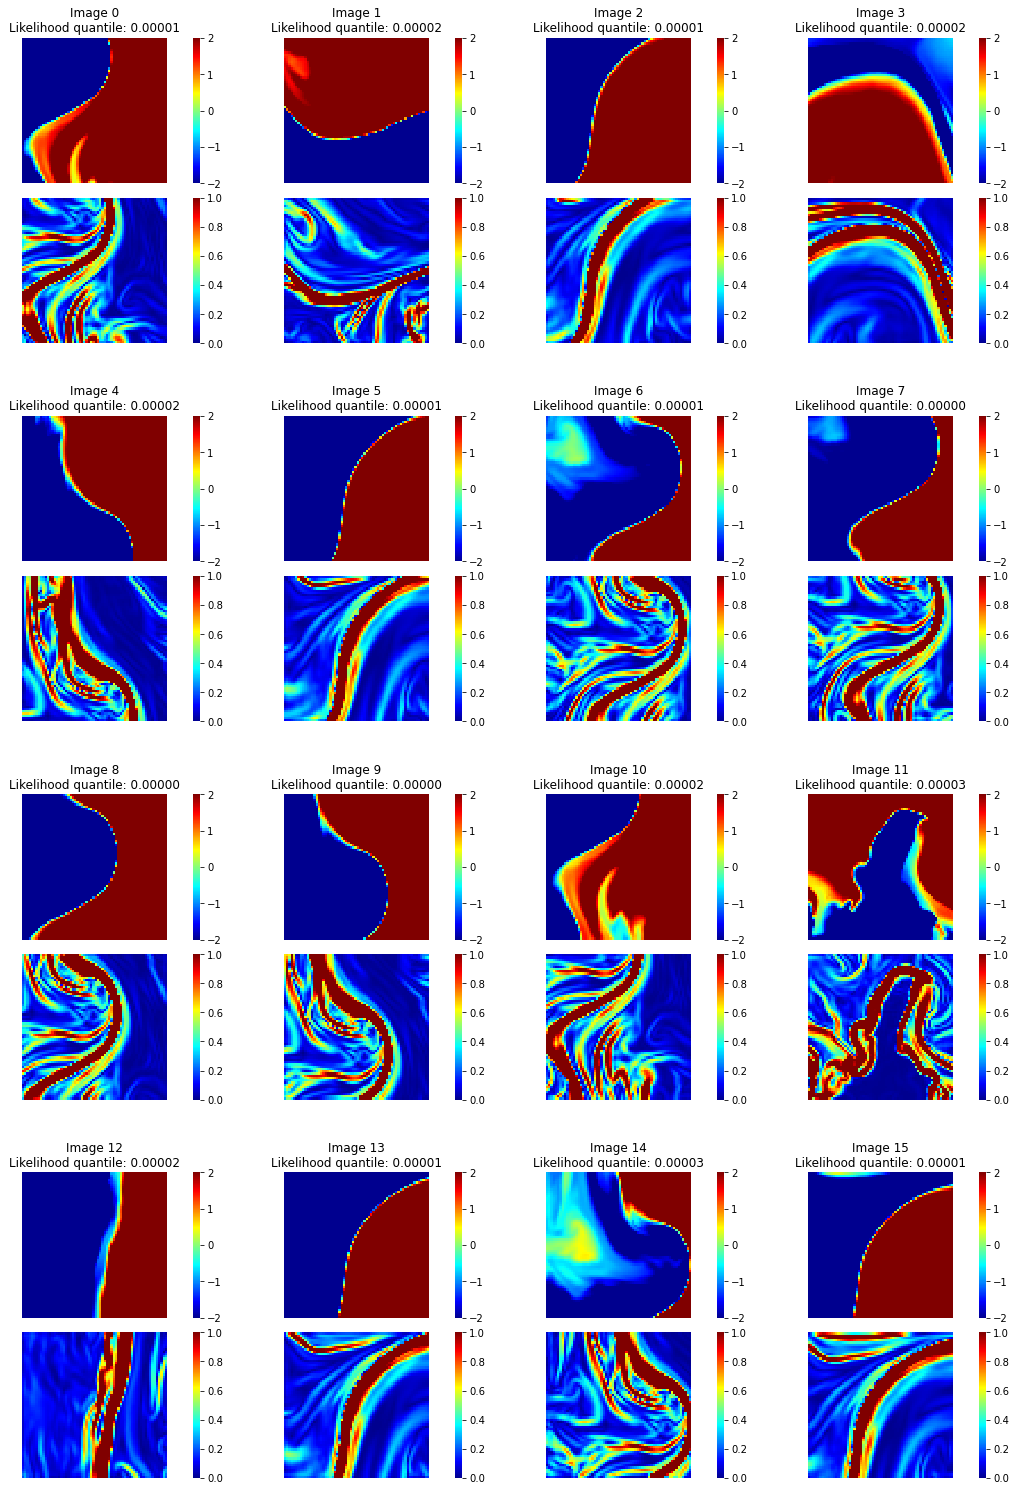

In [8]:
pae.plot_grid('least likely')

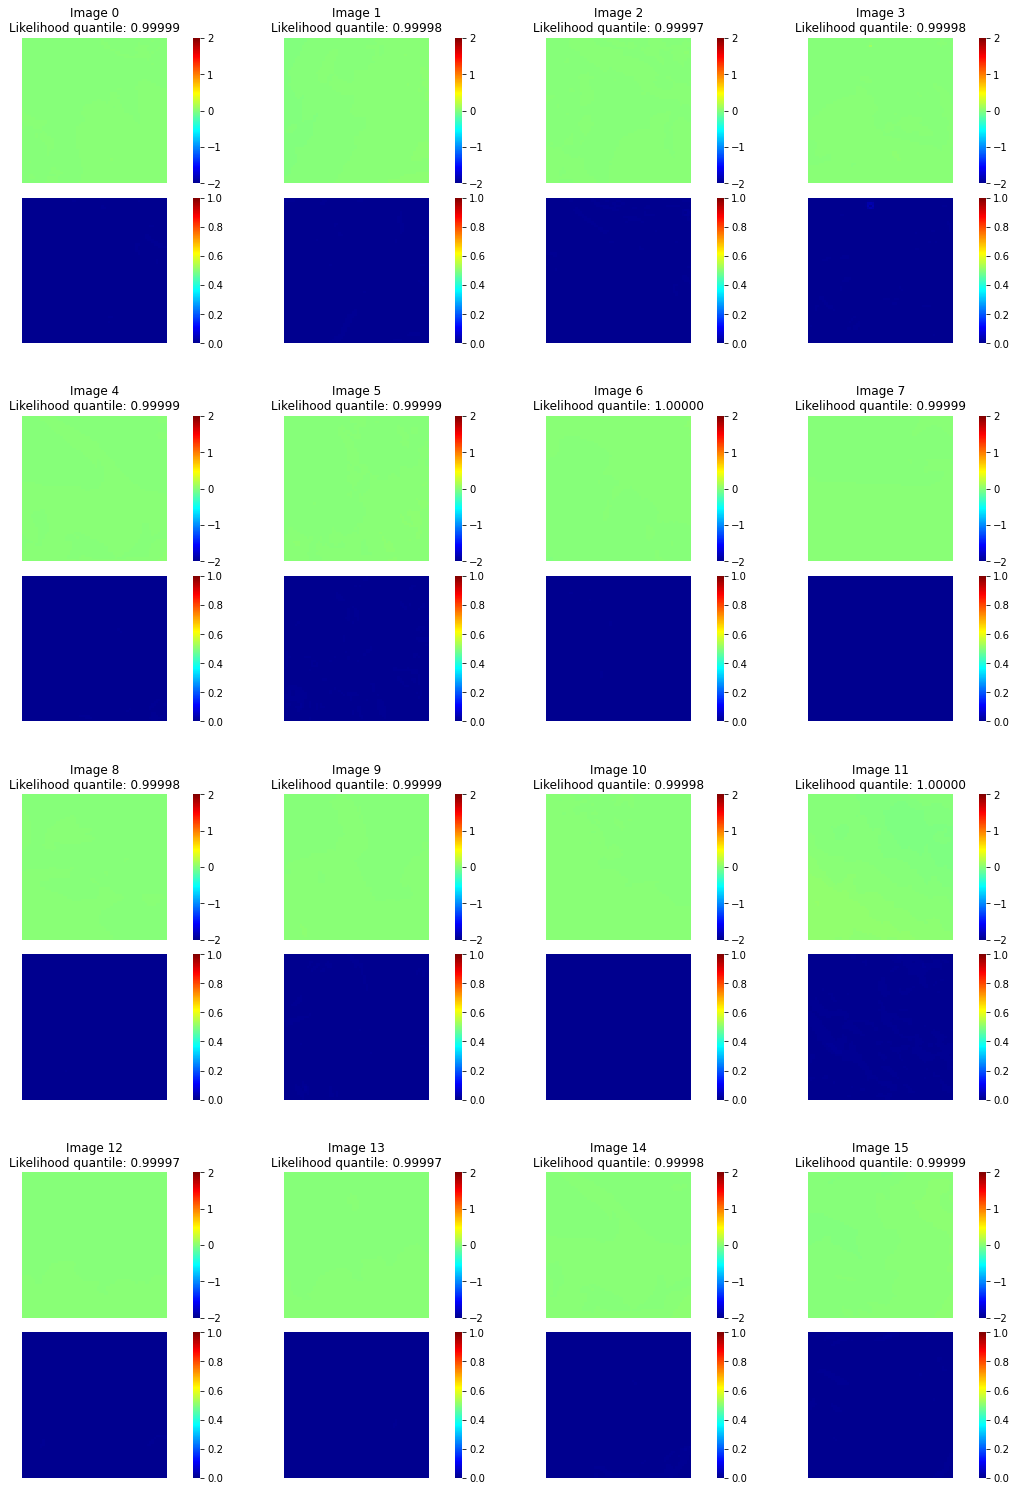

In [9]:
pae.plot_grid('most likely')

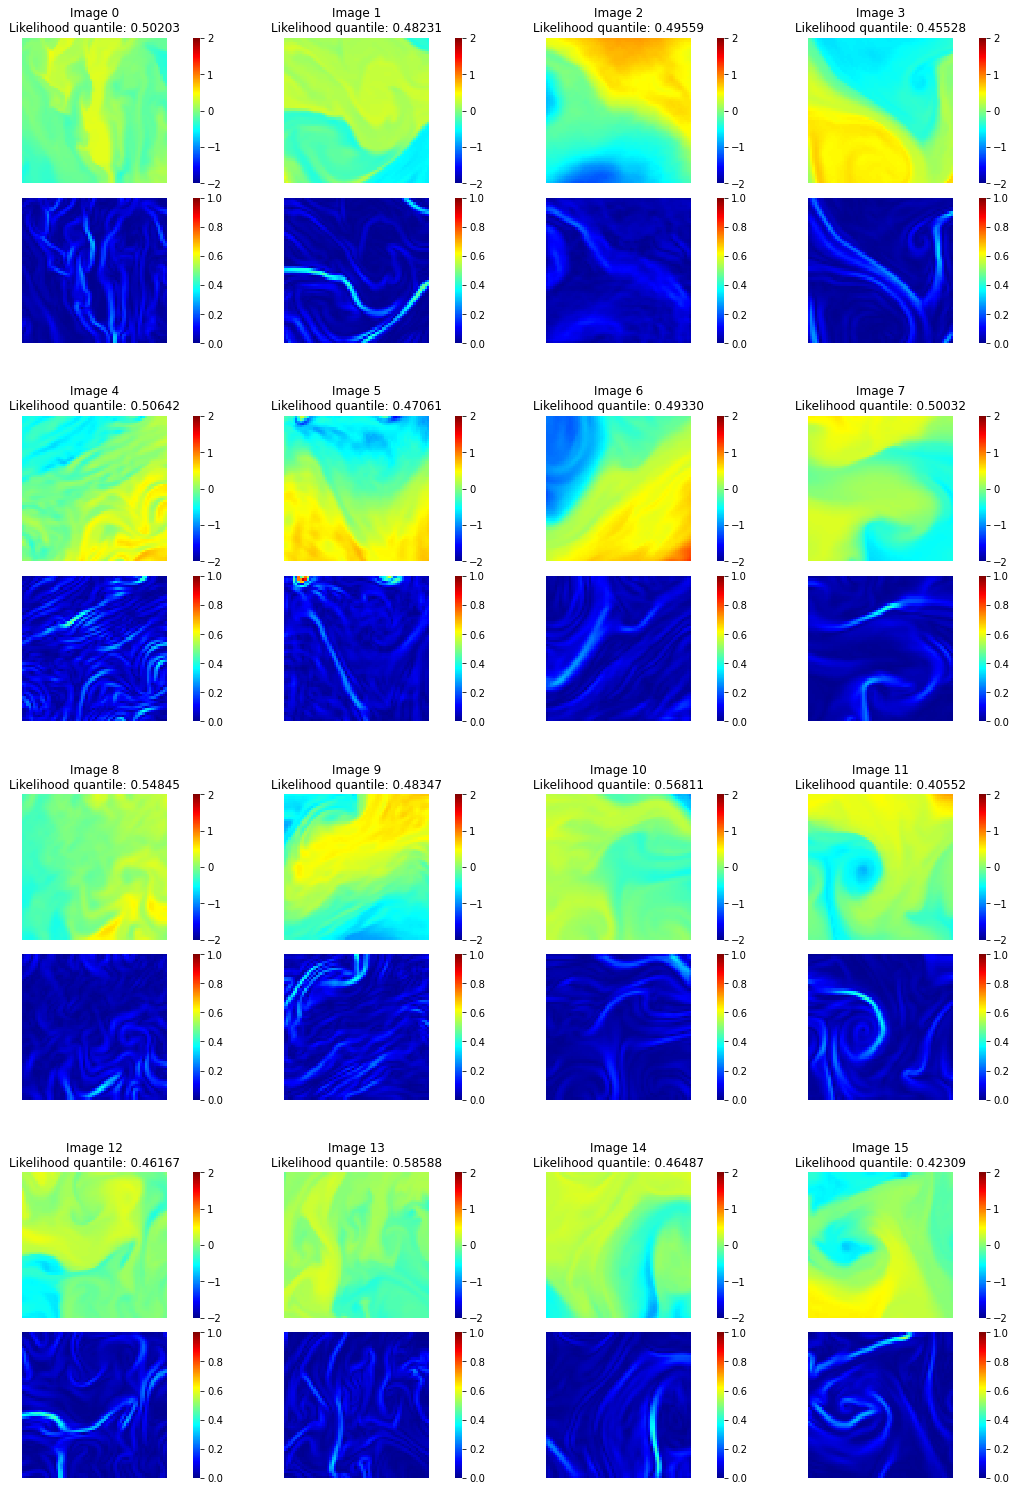

In [10]:
pae.plot_grid('midliers')